Using Open Bandits Pipeline **[1]**

**[1]** https://arxiv.org/pdf/2008.07146.pdf

In [ ]:
!pip install stanscofi

In [ ]:
from stanscofi.utils import load_dataset
from stanscofi.datasets import Dataset

## Load dataset
transcript_args = load_dataset("TRANSCRIPT")
transcript_args.update({"name": "TRANSCRIPT", "same_item_user_features": True})
transcript = Dataset(**transcript_args)

transcript.visualize(withzeros=False)

In [40]:
??transcript

In [3]:
transcript.ratings_mat.shape  # 613 drugs 151 diseases

(613, 151)

In [4]:
transcript.users.shape

(12096, 151)

In [5]:
transcript.items.shape

(12096, 613)

In [6]:
from scipy.sparse import coo_matrix
import pandas as pd
import numpy as np

def from_data_to_X(dataset):
    M = coo_matrix(dataset.ratings_mat)
    drugs = M.row
    diseases = M.col
    ratings = M.data
    df = pd.DataFrame(np.column_stack([drugs, diseases, ratings]), columns=('drug', 'disease', 'rating'))
    # df.head()
    
    X = transcript.items.T[drugs] * transcript.users.T[diseases]
    
    return X, df['rating']

In [8]:
X, y = from_data_to_X(transcript)
X.shape, y.shape

((412, 12096), (412,))

In [39]:
transcript.items.T[drugs].shape

(412, 12096)

In [41]:
transcript.users.T[diseases].shape

(412, 12096)

In [59]:
#plt.imshow(transcript.items)

In [73]:
df['rating'].value_counts()

 1    401
-1     11
Name: rating, dtype: int64

In [66]:
coo_matrix(transcript.users).getnnz()

80701

In [65]:
transcript.users.shape

(12096, 151)

In [64]:
(12096 * 613)

7414848

In [54]:
transcript.items.min(), transcript.items.max()

(-0.5639870762825012, 0.4877828657627105)

In [55]:
transcript.users.min(), transcript.users.max()

(-0.7248830795288086, 0.6328290104866028)

In [45]:
df['plus'] = (transcript.items.T[drugs] + transcript.users.T[diseases]).mean(axis=1)

In [46]:
df['minus'] = (transcript.items.T[drugs] - transcript.users.T[diseases]).sum(axis=1)

In [67]:
df['prod'] = (transcript.items.T[drugs] * transcript.users.T[diseases]).sum(axis=1)

In [1]:
# X, y = stanscofi.preprocessing.same_feature_preprocessing(transcript)

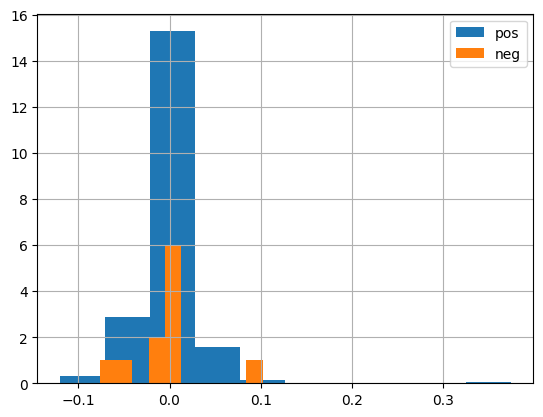

In [71]:
import matplotlib.pyplot as plt

df.query("rating == 1")['prod'].hist(label='pos', density=True)
df.query("rating == -1")['prod'].hist(label='neg')
plt.legend()

In [11]:
import stanscofi.training_testing

dataset = transcript
test_size=0.2
metric = 'cosine'
random_state = 42
train_folds, test_folds, _,_ = stanscofi.training_testing.traintest_validation_split(dataset, test_size=test_size, 
    early_stop=1, metric=metric, disjoint_users=False, verbose=False, random_state=random_state, print_dists=True)

<training_testing.traintest_validation_split> The sets of items/drugs in the training/testing datasets are disjoint.
<training_testing.traintest_validation_split> The sets of users/diseases in the training/testing datasets are *not* disjoint.
<training_testing.traintest_validation_split> Distances:
              Train set  Test set
Train set  3.330669e-16  0.601229
Test set   6.012292e-01  0.263550


In [12]:
train_data = transcript.get_folds(train_folds)
test_data = transcript.get_folds(test_folds)

In [13]:
X_train, y_train = from_data_to_X(train_data)
X_test, y_test = from_data_to_X(test_data)

In [39]:
from collections import Counter

Counter(y_train), Counter(y_test)

(Counter({1: 321, -1: 9}), Counter({1: 80, -1: 2}))

In [40]:
X_train.shape, X_test.shape

((330, 12096), (82, 12096))

In [15]:
from sklearn.linear_model import LogisticRegression

In [43]:
lr = LogisticRegression()#class_weight='balanced')

lr.fit(X_train, y_train)

LogisticRegression()

In [44]:
lr.score(X_train, y_train)

0.9727272727272728

In [45]:
lr.score(X_test, y_test)

0.975609756097561

In [46]:
#X_pred = lr.predict_proba(X_test)
#X_pred

In [54]:
scores = lr.predict_proba(X_test)[:, 0]
scores

array([0.02727272, 0.02727235, 0.02727268, 0.02727377, 0.02727271,
       0.02726897, 0.02727289, 0.02726916, 0.02727764, 0.02727365,
       0.02727223, 0.02727559, 0.02727273, 0.02727112, 0.02727343,
       0.02727536, 0.02727705, 0.02727299, 0.02727322, 0.02728024,
       0.02727379, 0.02727281, 0.02727346, 0.02727371, 0.02727007,
       0.02727007, 0.02727226, 0.02727483, 0.02727692, 0.02727495,
       0.02727253, 0.02726971, 0.02727014, 0.02727275, 0.02727562,
       0.02726738, 0.02726905, 0.02727267, 0.02726738, 0.02727246,
       0.02727308, 0.0272735 , 0.0272725 , 0.02727203, 0.02727595,
       0.02727292, 0.02727331, 0.02727253, 0.02727487, 0.02726357,
       0.02727322, 0.02727196, 0.02729541, 0.02726456, 0.02727155,
       0.02727225, 0.02727269, 0.02727266, 0.02727262, 0.02727221,
       0.02727246, 0.02727308, 0.0272735 , 0.02727184, 0.02727281,
       0.02727271, 0.0272727 , 0.02727259, 0.02727255, 0.02727182,
       0.02727262, 0.02727258, 0.02727294, 0.02727073, 0.02727

In [50]:
Counter(y_test)

Counter({1: 80, -1: 2})

In [68]:
df_res = pd.DataFrame(np.column_stack([scores, y_test]), columns=('pred', 'truth'))

In [69]:
df_res.head()

,pred,truth
0,0.027273,1.0
1,0.027272,1.0
2,0.027273,1.0
3,0.027274,1.0
4,0.027273,1.0


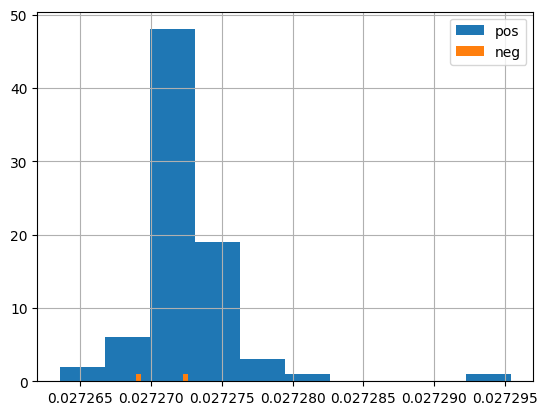

In [72]:
import matplotlib.pyplot as plt

df_res.query('truth == 1')['pred'].hist(label='pos')
df_res.query('truth == -1')['pred'].hist(label='neg')
plt.legend()

In [61]:
from sklearn.metrics import roc_auc_score, accuracy_score

roc_auc_score((y_test + 1) // 2, scores)

0.7437499999999999

In [62]:
accuracy_score((y_test + 1) // 2, scores.round())

0.024390243902439025

In [36]:
lr.predict_proba(X_test)

array([[0.49944519, 0.50055481],
       [0.49941237, 0.50058763],
       [0.49944109, 0.50055891],
       [0.49953805, 0.50046195],
       [0.49944354, 0.50055646],
       [0.49911299, 0.50088701],
       [0.49945947, 0.50054053],
       [0.4991301 , 0.5008699 ],
       [0.49988044, 0.50011956],
       [0.4995272 , 0.5004728 ],
       [0.49940163, 0.50059837],
       [0.49969854, 0.50030146],
       [0.49944539, 0.50055461],
       [0.49930295, 0.50069705],
       [0.49950731, 0.50049269],
       [0.49967806, 0.50032194],
       [0.49982791, 0.50017209],
       [0.49946897, 0.50053103],
       [0.4994893 , 0.5005107 ],
       [0.5001105 , 0.4998895 ],
       [0.49953963, 0.50046037],
       [0.49945232, 0.50054768],
       [0.4995101 , 0.5004899 ],
       [0.49953217, 0.50046783],
       [0.49920984, 0.50079016],
       [0.49920984, 0.50079016],
       [0.49940446, 0.50059554],
       [0.49963166, 0.50036834],
       [0.49981608, 0.50018392],
       [0.49964233, 0.50035767],
       [0.

In [25]:
metrics, plot_args = stanscofi.validation.compute_metrics(scores, predictions, test_dataset, 
                                                          ignore_zeroes=False, verbose=True)

NameError: name 'scores' is not defined

In [7]:
from importlib import reload
import sys
sys.path.insert(0,"src/")
import benchscofi

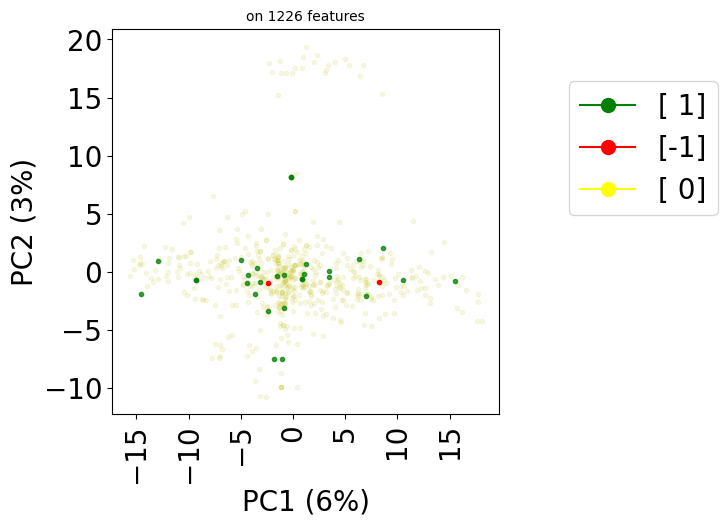

In [8]:
## Restrict to a single disease
import numpy as np

## Which is the disease with the most ratings?
disease_idx = np.argmax(np.abs(transcript.ratings_mat).sum(axis=0))
disease_folds = np.asarray(np.zeros((transcript.ratings_mat.shape[0],3)), dtype=int)
disease_folds[:,0] = disease_idx
disease_folds[:,1] = list(range(transcript.ratings_mat.shape[0]))
disease_folds[:,2] = transcript.ratings_mat[:,disease_idx].ravel()
subset = transcript.get_folds(disease_folds) ## restrict to that disease

subset.visualize(withzeros=True)

In [9]:
## Directly use a_i+theta ~ log(FC) as action feature vectors 
import numpy as np

def same_feature_preprocessing(dataset):
    assert dataset.same_item_user_features
    y = np.ravel(dataset.ratings_mat.flatten())
    S_, P_ = dataset.items.T.copy(), dataset.users.T.copy()
    P_[np.isnan(P_)] = 0
    S_[np.isnan(S_)] = 0
    ids = np.argwhere(np.ones(dataset.ratings_mat.shape)) # (item, user) pairs
    X = np.concatenate(tuple([
        np.add(S_[i, :], P_[j, :]).reshape(-1,1) ## a_i+theta
        for i, j in ids.tolist()
    ]), axis=1).T ## pairs x features
    return X, y

In [10]:
X, y = same_feature_preprocessing(subset)
(X.shape, y.shape)

((613, 12096), (613,))

In [24]:
FeatureDrugs = subset.items.T.copy()
FeatureDiseases = subset.users.T.copy()

## is it sparse?
print("Perc. of zero values in drug feature vector %.2f perc. (N=%d drugs)" 
 % (np.sum(FeatureDrugs==0)*100/(FeatureDrugs.shape[0]*FeatureDrugs.shape[1]), FeatureDrugs.shape[0]))
print("Perc. of zero values in disease feature vector %.2f perc. (N=%d diseases)" 
 % (np.sum(FeatureDiseases==0)*100/(FeatureDiseases.shape[0]*FeatureDiseases.shape[1]), FeatureDiseases.shape[0]))

## do cosine distance scores match reported outcomes?
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr
cos_distances = 1-cosine_similarity(FeatureDrugs, FeatureDiseases)
res = spearmanr(cos_distances[y!=0], y[y!=0])
print("Spearman's r correlation %.3f" % res.correlation)

Perc. of zero values in drug feature vector 45.35 perc. (N=613 drugs)
Perc. of zero values in disease feature vector 95.51 perc. (N=1 diseases)
Spearman's r correlation 0.059


In [25]:
from obp.dataset import MultiClassToBanditReduction
from obp.ope import OffPolicyEvaluation, InverseProbabilityWeighting as IPW

In [27]:
random_seed=12345

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

dataset = MultiClassToBanditReduction(X=X, y=y, 
                    base_classifier_b=LogisticRegression(random_state=random_seed))
dataset.split_train_eval(eval_size=0.7, random_state=random_seed)
bandit_feedback = dataset.obtain_batch_bandit_feedback(random_state=random_seed)

# obtain action choice probabilities of an evaluation policy
action_dist = dataset.obtain_action_dist_by_eval_policy(
    base_classifier_e=RandomForestClassifier(random_state=random_seed)
)
# calculate the ground-truth performance of the evaluation policy
ground_truth = dataset.calc_ground_truth_policy_value(action_dist=action_dist)
print("Ground truth perf = %.3f" % ground_truth)

# Off-Policy Evaluation
ope = OffPolicyEvaluation(bandit_feedback=bandit_feedback, ope_estimators=[IPW()])
# evaluate the estimation performance (accuracy) of IPW by the relative estimation 
# error (relative-ee)
relative_estimation_errors = ope.evaluate_performance_of_estimators(
        ground_truth_policy_value=ground_truth,
        action_dist=action_dist,
        metric="relative-ee",
)
print("Relative EE (%s) = %.3f" % [(k,relative_estimation_errors[k])
                                         for k in relative_estimation_errors][0])

Ground truth perf = 0.951
Relative EE (ipw) = 0.955


In [28]:
action_dist.shape ## TODO why 430 down from 613??

(430, 3, 1)